<a href="https://colab.research.google.com/github/Dimildizio/system_design/blob/main/metrics_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Check metrics for a specific dataset

## Installs

In [1]:
%%capture
!pip install rouge-score sacrebleu #sentencepiece

## Imports

In [2]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sacrebleu
#import sentencepiece as sp

from google.colab import files
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from sacrebleu.metrics import BLEU, CHRF
from typing import List, Dict, Callable

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

##Load dataset

In [4]:
FILENAME = 'all_translations.tsv'

In [19]:
df = pd.read_csv(FILENAME, sep='\t')
df = df.drop('en_marian', axis=1)

## Create metrics

#### aux rounding func

In [6]:
def round_perc(num: float) -> float:
  return round(num*100, 2)

### Rouge

In [7]:
Rouge1 = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
Rouge2 = rouge_scorer.RougeScorer(['rouge2'], use_stemmer=True)
RougeL = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

In [8]:
def eval_rouge1(translation, reference):
  return round_perc(Rouge1.score(reference, translation)['rouge1'].fmeasure)

def eval_rouge2(translation, reference):
  return round_perc(Rouge2.score(reference, translation)['rouge2'].fmeasure)

def eval_rougeL(translation, reference):
  return round_perc(RougeL.score(reference, translation)['rougeL'].fmeasure)

### BLEU

In [9]:
smoothing_zero_ngrams = SmoothingFunction()

In [10]:
def get_sent_bleu(sentence: str, reference: str) -> float:
  score = sentence_bleu([reference.split()], sentence.split(),
                        weights = (0.25, 0.5, 0.25), smoothing_function=smoothing_zero_ngrams.method1)
  return round_perc(score)


def get_bleu(sentence: str, reference: str) -> float:
  score = corpus_bleu([[reference.split()]], [sentence.split()],
                      smoothing_function=smoothing_zero_ngrams.method1)
  return round_perc(score)

def get_sacrebleu(sent_series, ref_series): #crutch
  #irrelevant scores
  for sent, ref in zip(sent_series, ref_series):
    return sacrebleu.corpus_bleu([sent], [[ref]])

def get_chrf(sentence, reference):
  chrf = CHRF()
  return round(chrf.corpus_score([sentence], [[reference]]).score, 2)


### meteor

In [11]:
def get_meteor(sentence: str, reference: str) -> float:
  score = meteor_score([reference.split()], sentence.split())
  return round_perc(score)

TER

In [12]:
def ter(hypothesis, reference) -> int:
    n = len(reference)
    m = len(hypothesis)

    dp = [[0] * (m + 1) for _ in range(n + 1)]

    for i in range(n + 1):
        dp[i][0] = i
    for j in range(m + 1):
        dp[0][j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = 0 if reference[i - 1] == hypothesis[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    return dp[n][m]

#### NIST

In [13]:
def nist(reference, hypothesis):
    n=3
    reference_ngrams = set([tuple(reference[i:i+n]) for i in range(len(reference)-n+1)])
    hypothesis_ngrams = set([tuple(hypothesis[i:i+n]) for i in range(len(hypothesis)-n+1)])

    precision = len(reference_ngrams.intersection(hypothesis_ngrams)) / len(hypothesis_ngrams)
    return round_perc(precision)

In [15]:
nist(df['en_expert'][0], df['en_auto'][0])

73.13

###Metrics

In [16]:
METRICS = {'bleu':  get_bleu,
           'sent_bleu': get_sent_bleu,
           #'sacre bleu': get_sacrebleu,
           'nist_3gram':nist,
           'meteor': get_meteor,
           'TER':ter,
           'CHRF++': get_chrf,
           'rouge1': eval_rouge1,
           'rouge2': eval_rouge2,
           'rougeL': eval_rougeL
           }

## Test functions

In [21]:
def apply_func(func: Callable, df: pd.DataFrame=df) -> pd.DataFrame:
  scores = pd.DataFrame(columns=df.columns[2:])
  for col in df.columns[2:]:
    scores[col] = df.apply(lambda row: func(row[col], row['en_expert']), axis=1)
  return scores

In [31]:
def test_metric(func: Callable, name: str, df: pd.DataFrame=df) -> None:
    result = apply_func(func, df)
    fig, ax = plt.subplots(figsize=(10,3))
    colors = result.plot.area(ax=ax, stacked=False, alpha=0.6).get_lines()

    for i, (col, mean_value) in enumerate(result.mean().items()):   #could also use median
        ax.axhline(y=mean_value, linestyle='--', color=colors[i].get_color(), label=f'Mean {col}: {mean_value:.2f}')

    ax.legend()
    plt.title(name)
    plt.show()

## Run the visualtization

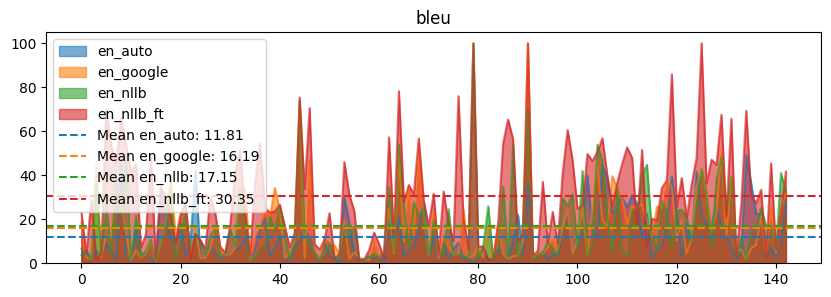

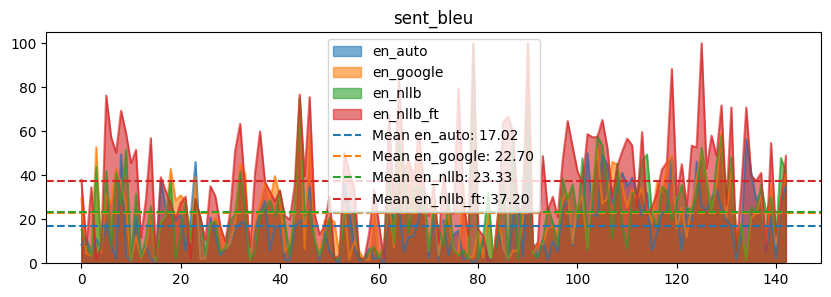

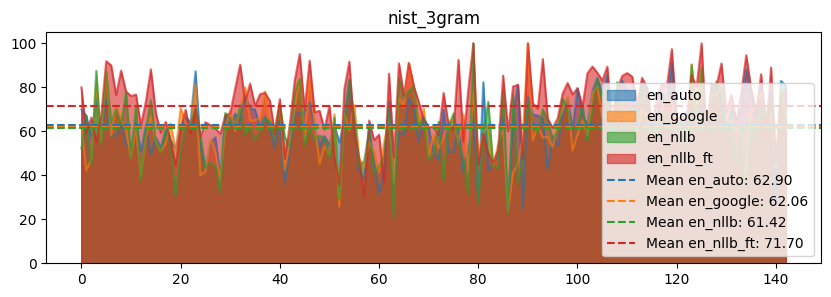

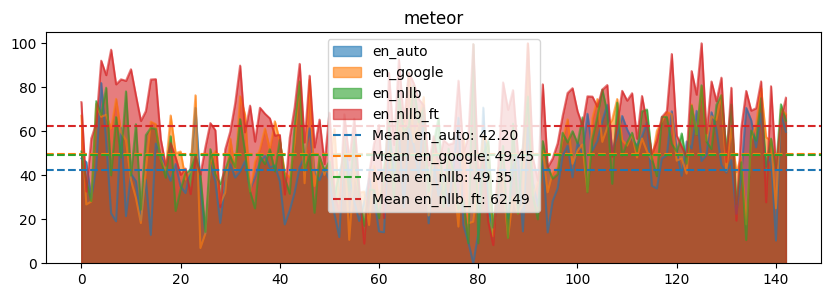

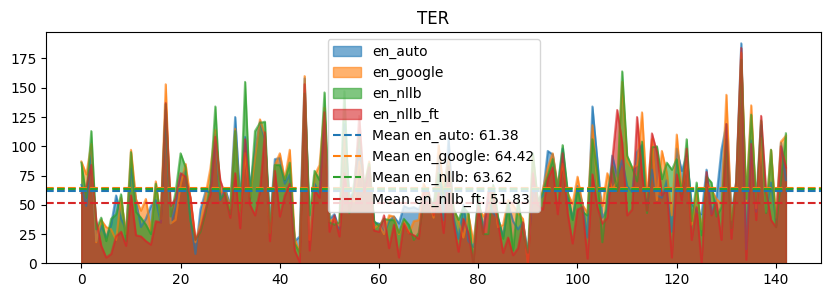

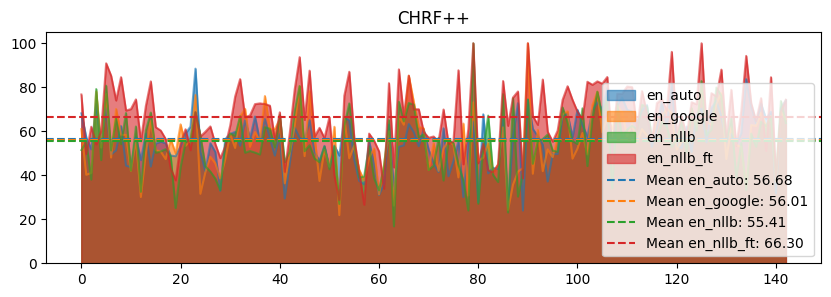

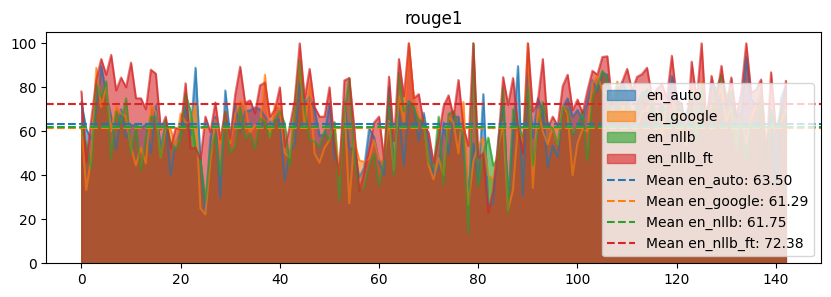

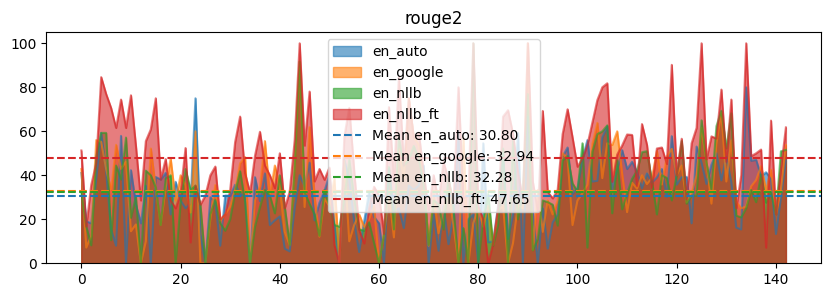

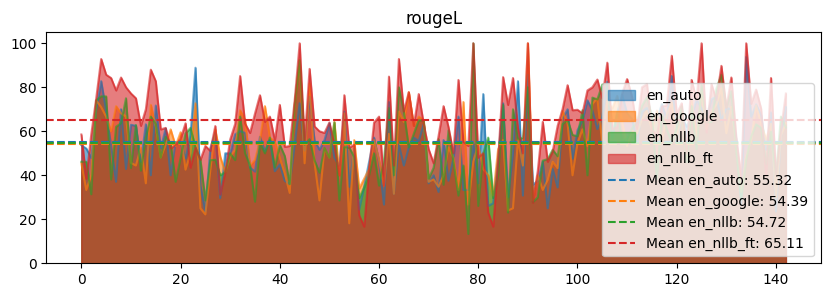

In [32]:
for name, func in METRICS.items():
  test_metric(func, name)

# Create a graph with a mean point for each metrics

In [26]:
def calc_metrics(df: pd.DataFrame, metrics_dict: Dict) -> Dict:
  '''Calculate metrics for each model and return as a dict name:metrics'''
  results = {}
  for model in df.columns[2:]:#['en_auto', 'en_google', 'en_nllb', 'en_marian']:
      model_results = {}
      for metric_name, metric_func in metrics_dict.items():
          model_results[metric_name] = [metric_func(ref, trans) for ref, trans in zip(df['en_expert'], df[model])]
      results[model] = model_results
  return results

def compute_means(results: Dict) -> pd.DataFrame:
  '''Compute the mean of each metric for each model and return as dataframe'''
  mean_results = {model: {metric: sum(values) / len(values) for metric,
                          values in model_results.items()}
                  for model, model_results in results.items()
                  }
  return pd.DataFrame(mean_results)


def plot_groupbar(means: pd.DataFrame, metrics_dict = False, minval=False) -> None:
  if metrics_dict:
    x = np.arange(len(metrics_dict))  #label locs
    barwidth = 0.2
    title = 'Mean metrics over Metrics for each Model'
    xnames = 'Metrics'

  else:
    x = np.arange(len(means.index))  #label locs
    barwidth = 0.1
    title = 'Mean metrics over Model for each Metric'
    xnames = 'Models'

  fig, ax = plt.subplots(figsize=(12, 3))
  min_values = means.min(axis=1) if minval else 0
  yoffset = 1 if minval else 0

  for i, model in enumerate(means.columns):
      bars = ax.bar(x + i*barwidth, means[model] - min_values+1, barwidth, label=model)
      for bar in bars:
          yval = bar.get_height()
          ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black', fontsize=6)

  ax.set_xlabel(xnames)
  ax.set_ylabel('Mean Value')
  ax.set_title(title)
  ax.set_ylim(bottom=0)

  ax.set_xticks(x + barwidth*(len(means.columns)/2))
  ax.set_xticklabels(means.index)
  offset = 1 if minval else 0
  ax.set_yticks(ax.get_yticks() + offset)
  ax.set_yticklabels(ax.get_yticks())
  ax.legend(loc='upper left')
  plt.show()

def calc_n_plot_means(df: pd.DataFrame, metrics_dict: Dict, minval=False) -> pd.DataFrame:
  metrics_results = calc_metrics(df, metrics_dict)
  results_means = compute_means(metrics_results)
  plot_groupbar(results_means, metrics_dict, minval=minval)
  plot_groupbar(results_means.T, minval=minval)
  return results_means

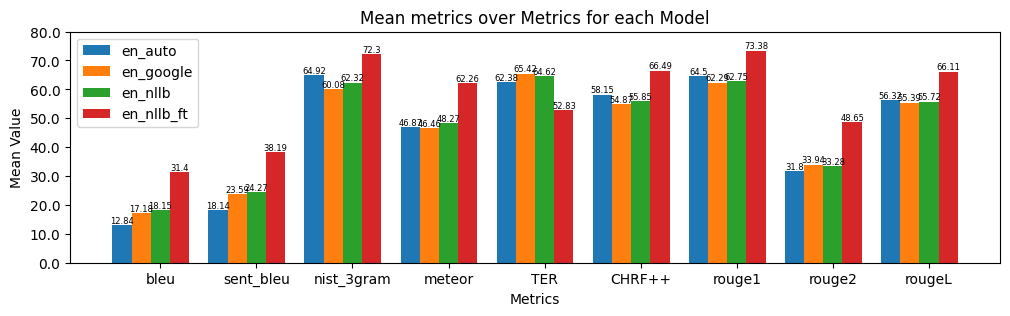

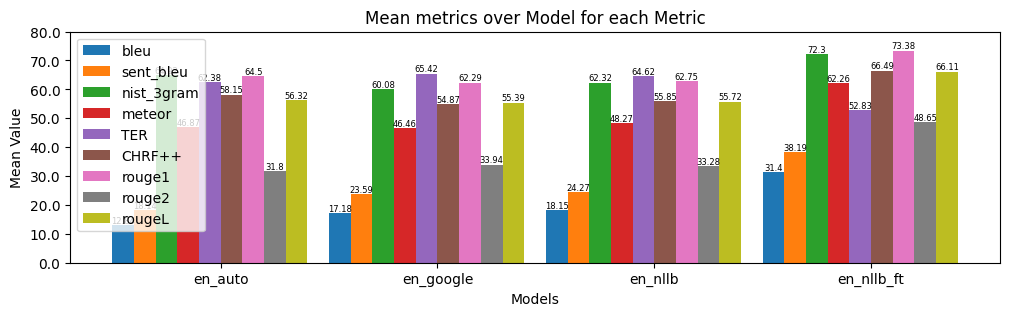

In [27]:
models_means = calc_n_plot_means(df, METRICS)

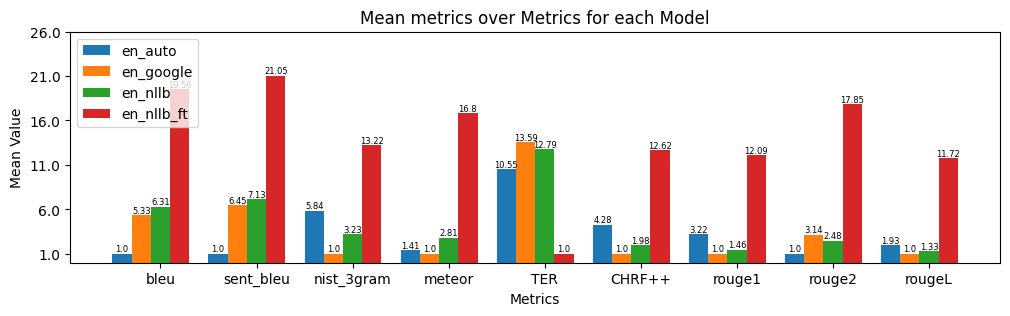

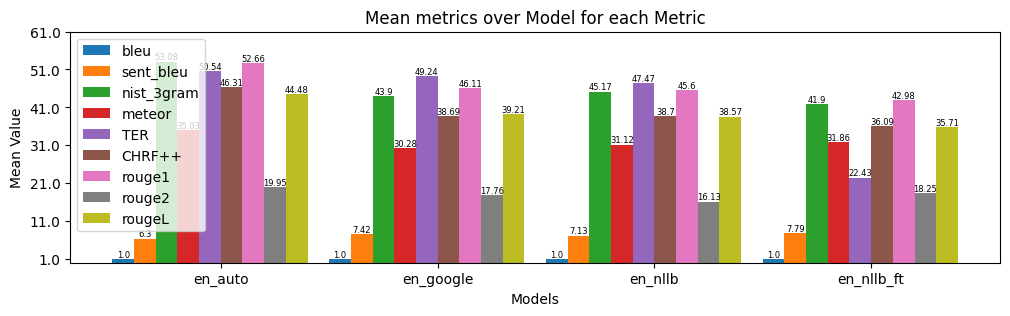

In [28]:
models_means_t = calc_n_plot_means(df, METRICS, True)

## Create DFs for further use

In [ ]:
def col_metrics(col:str) -> pd.DataFrame:
  '''Return a dataframe if only values required.
     otherwise use cometrics_df to create a df with input and ref text'''
  scores = pd.DataFrame()
  for name, func in METRICS.items():
    scores[col+'_'+name] = df.apply(lambda row: func(row[col], row['en_expert']), axis=1)
  return scores


def colmetrics_df(col:str) -> pd.DataFrame:
  '''Return and dataframe with metrics, original input and reference expert translation'''
  metric = col_metrics(col)
  newdf = df[['ru', 'en_expert']].copy()
  for col in metric.columns:
    newdf[col]=metric[col]
  return newdf


def dfs_with_metrics() -> Dict:
  '''Return a list of all dataframes with metrics, original input and ref translation'''
  return {col:colmetrics_df(col) for col in df.columns[2:]}


def just_metrics() -> pd.DataFrame:
  '''Return a dataframe that has only metrics without text'''
  new_df = pd.DataFrame()
  for dataframe in dfs_with_metrics().values():
    for col in dataframe.columns:
      if col not in df.columns:
        new_df[col] = dataframe[col]
  return new_df


def save_df(name, dataframe, download=True) -> None:
  '''Save one dataframe as .tsv
    (optional) downloads it'''
  filename = name + '_metrics.tsv'
  dataframe.to_csv(filename, sep='\t')
  if download:
    files.download(filename)


def save_all_dfs(download=True) -> None:
  for name, dataframe in dfs_with_metrics().items():
    save_df(name, dataframe, download)

#### Save dataframes

In [ ]:
save_df('numbers', just_metrics()) #just values with all columns

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
save_all_dfs()  # metrics for different models

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>